In [1]:
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
# sklearn
from sklearn.model_selection import train_test_split

In [2]:
import DataStats
import PipeTransformers

# Use stratify method to split train and test data sets from original data

In [3]:
data = pd.read_csv('../data/original_data.csv').drop(columns=['Unnamed: 0'])
# remove the rows that have NaN values in the sfdm2 column
data_target_missing = data[data['sfdm2'].isna()] 
data = data.dropna(subset=['sfdm2'])

In [4]:
# data_target_missing.to_csv('../data/original_data_target_missing.csv', index=False)

In [5]:
# the target and features
y = data["sfdm2"]
X = data.drop(columns=['sfdm2'])
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")  

X shape: (7705, 47)
y shape: (7705,)


In [6]:
# split the data into train and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,            # 20% for test
    random_state=1,          # for reproducibility
    stratify=y                # this keeps class distribution consistent
)

In [7]:
# conbine the train and test sets
X_train['sfdm2'] = y_train
X_test['sfdm2'] = y_test
# make sure naming consistent
train_data = X_train
test_data = X_test
# save the train and test sets
# train_data.to_csv('../data/train_data.csv', index=False)
# test_data.to_csv('../data/test_data.csv', index=False)

## Check the propotion of labels in target variable in the two data sets

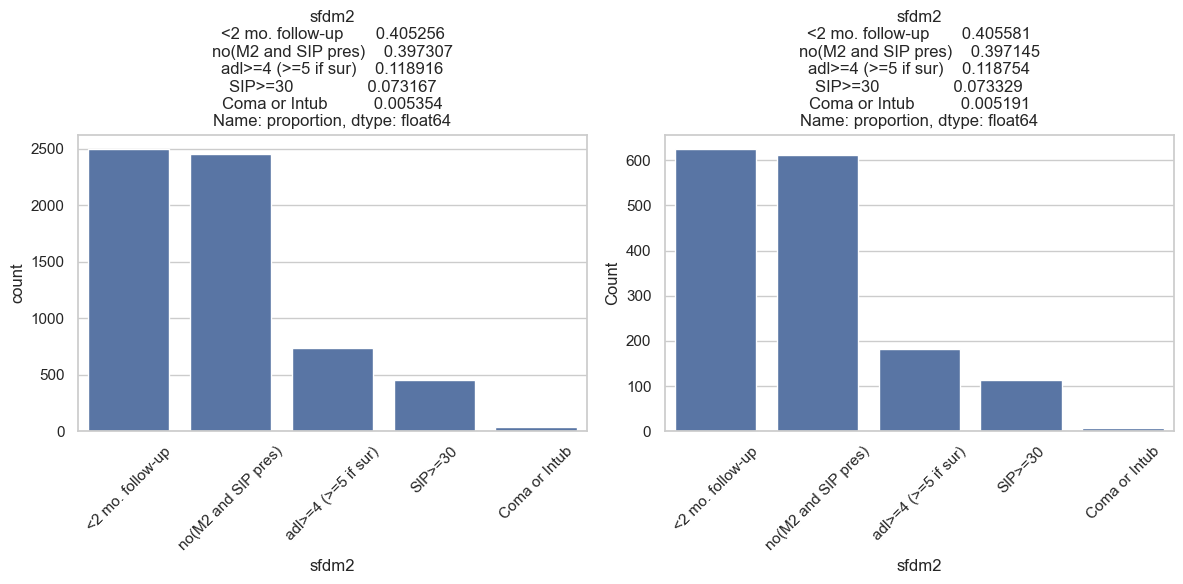

In [47]:
# print the proportion of different target values
# print("The ratio of the target in the train set and test set is:")
# print(train_data['sfdm2'].value_counts(normalize=True))
# print(test_data['sfdm2'].value_counts(normalize=True))

# visualize the ratio of the target in the train set and test set
def _visualize_target_ratio():
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Order x-values in descending order for train_data
    train_order = train_data['sfdm2'].value_counts(ascending=False).index
    sns.countplot(x='sfdm2', data=train_data, ax=axes[0], order=train_order)
    axes[0].set_title(train_data['sfdm2'].value_counts(normalize=True))
    axes[0].tick_params(axis='x', rotation=45)

    # Order x-values in descending order for test_data
    test_order = test_data['sfdm2'].value_counts(ascending=False).index
    sns.countplot(x='sfdm2', data=test_data, ax=axes[1], order=test_order)
    axes[1].set_title(test_data['sfdm2'].value_counts(normalize=True))
    axes[1].tick_params(axis='x', rotation=45)

    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('../results/train_test_target_proportion.png', dpi=300)
    plt.show()

# check the ratio of the target in the train set and test set
_visualize_target_ratio()

## What to do next

Now we have stratified the sample into trian and test sets. 

We will start building our models on the train data, which means **we are going to use train data only.**

We first **use the created pipeline(s) to impute and encode the variables in train data.** 

Then we will **check the distributions** about these variables visually, **detect potential outliers** and 
**make necessary transformations** on these variables.

In [30]:
# update data to train_data
data = pd.read_csv('../data/train_data.csv')
data.shape

(6164, 48)

In [10]:
# initialize the data cleaning transformers
importlib.reload(PipeTransformers)
imputer_encoder_transformers = PipeTransformers.create_imputer_encoder_pipelines()
imputer_encoder_transformers[0]

ColumnTransformer(transformers=[('num_imputer',
                                 Pipeline(steps=[('imputer', SimpleImputer())]),
                                 ['id', 'age', 'death', 'hospdead', 'slos',
                                  'd.time', 'num.co', 'edu', 'scoma', 'charges',
                                  'totcst', 'totmcst', 'avtisst', 'sps', 'aps',
                                  'surv2m', 'surv6m', 'hday', 'prg2m', 'prg6m',
                                  'dnrday', 'meanbp', 'wblc', 'hrt', 'resp',
                                  'temp', 'pafi', 'alb', 'bili', 'crea', ...]),
                                ('num_boolean_imp...
                                 ['income', 'dnr', 'sfdm2']),
                                ('cat_oh_encoder',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['race', 'sex', 'dzgroup', 'ca', 'dzclass']),
                                ('cat_sim_encoder',
                                 Pipeline(steps=[('cat_sim_encoder',
                                                  CustomFunctionTransformer(func=<function create_imputer_encoder_pipelines.<locals>.cat_sim_maps_func at 0x3081256c0>))]),
                                 ['income', 'dnr', 'sfdm2'])])

In [11]:
# try the transformers on the train data
from PipeTransformers import imputer_encoder_transform
imputer_encoder_transform(imputer_encoder_transformers[10], data) # works well

/Users/gufeng/2025_winter/DASC_5420/Final_Project_5420/src/PipeTransformers.py:214: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  transformed_data[missing_col] = transformed_data[missing_col].fillna(mean_value)


,num_imputer__id,num_imputer__age,num_imputer__death,num_imputer__hospdead,num_imputer__slos,num_imputer__d.time,num_imputer__num.co,num_imputer__edu,num_imputer__scoma,num_imputer__charges,...,cat_oh_encoder__ca_metastatic,cat_oh_encoder__ca_no,cat_oh_encoder__ca_yes,cat_oh_encoder__dzclass_ARF/MOSF,cat_oh_encoder__dzclass_COPD/CHF/Cirrhosis,cat_oh_encoder__dzclass_Cancer,cat_oh_encoder__dzclass_Coma,cat_sim_encoder__income,cat_sim_encoder__dnr,cat_sim_encoder__sfdm2
0,231.0,77.74695,1.0,0.0,6.0,422.0,1.0,12.0,0.0,16325.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0
1,5089.0,69.64294,0.0,0.0,15.0,674.0,3.0,12.0,0.0,58826.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0
2,2579.0,61.91397,1.0,1.0,22.0,22.0,2.0,9.0,0.0,69577.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,5.0
3,8988.0,83.39496,0.0,0.0,49.0,485.0,0.0,13.0,0.0,112915.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,2.0
4,8696.0,69.84796,1.0,0.0,20.0,24.0,2.0,10.0,89.0,58550.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6159,8352.0,58.55197,1.0,0.0,5.0,74.0,1.0,12.0,0.0,3079.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,2.0
6160,8635.0,81.81195,1.0,1.0,8.0,8.0,1.0,14.0,0.0,66049.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,5.0
6161,1433.0,33.043,0.0,0.0,62.0,515.0,3.0,11.0,37.0,584811.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0
6162,8070.0,62.245,0.0,0.0,15.0,1685.0,1.0,12.0,0.0,15038.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0


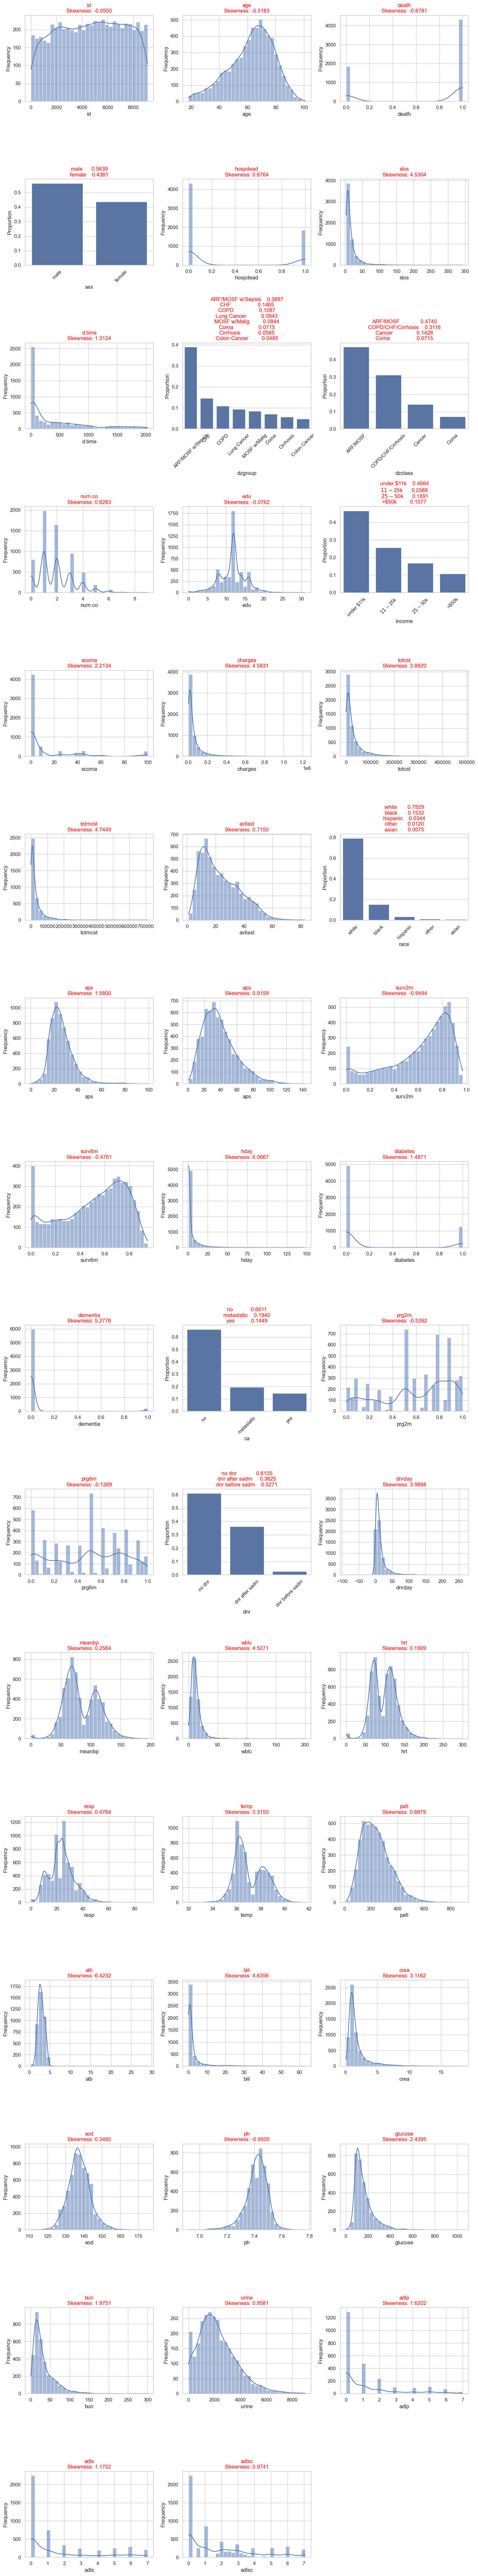

In [12]:
# visualzie the feature distributions
def visualize_feature_distributions(data, save = False, saving_path = 'feature_distributions'):
    # Set the style of seaborn
    sns.set_theme(style="whitegrid")

    # Create a figure with subplots
    num_features = data.shape[1] - 1  # Exclude the target variable
    fig, axes = plt.subplots(nrows=(num_features + 2) // 3, ncols=3, figsize=(15, 5 * ((num_features + 2) // 3)))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Loop through each feature
    for i, column in enumerate(data.columns[:-1]):  # Exclude the target variable
        if data[column].dtype in ['float64', 'int64']:  # Numerical variables
            sns.histplot(data[column].dropna(), bins=30, kde=True, ax=axes[i])
            skewness = skew(data[column].dropna())
            axes[i].set_title(f'{column}\nSkewness: {skewness:.4f}', color='red')
            axes[i].set_xlabel(column)
            axes[i].set_ylabel('Frequency')
        else:  # Categorical variables
            proportions = data[column].value_counts(normalize=True).round(4)
            sns.barplot(x=proportions.index, y=proportions.values, ax=axes[i])
            proportions_string = proportions.to_string(index=True, header=False)
            axes[i].set_title(f'{proportions_string}', color = 'red')
            axes[i].set_xlabel(column)
            axes[i].set_ylabel('Proportion')
            axes[i].tick_params(axis='x', rotation=45)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    if save:
        plt.savefig(f'../results/images/{saving_path}.png', dpi=300)
    plt.show()

# Visualize the distributions of the features in data
visualize_feature_distributions(data, save = True, saving_path = 'orginal_feature_distributions.png')
# visualize_feature_distributions(data)

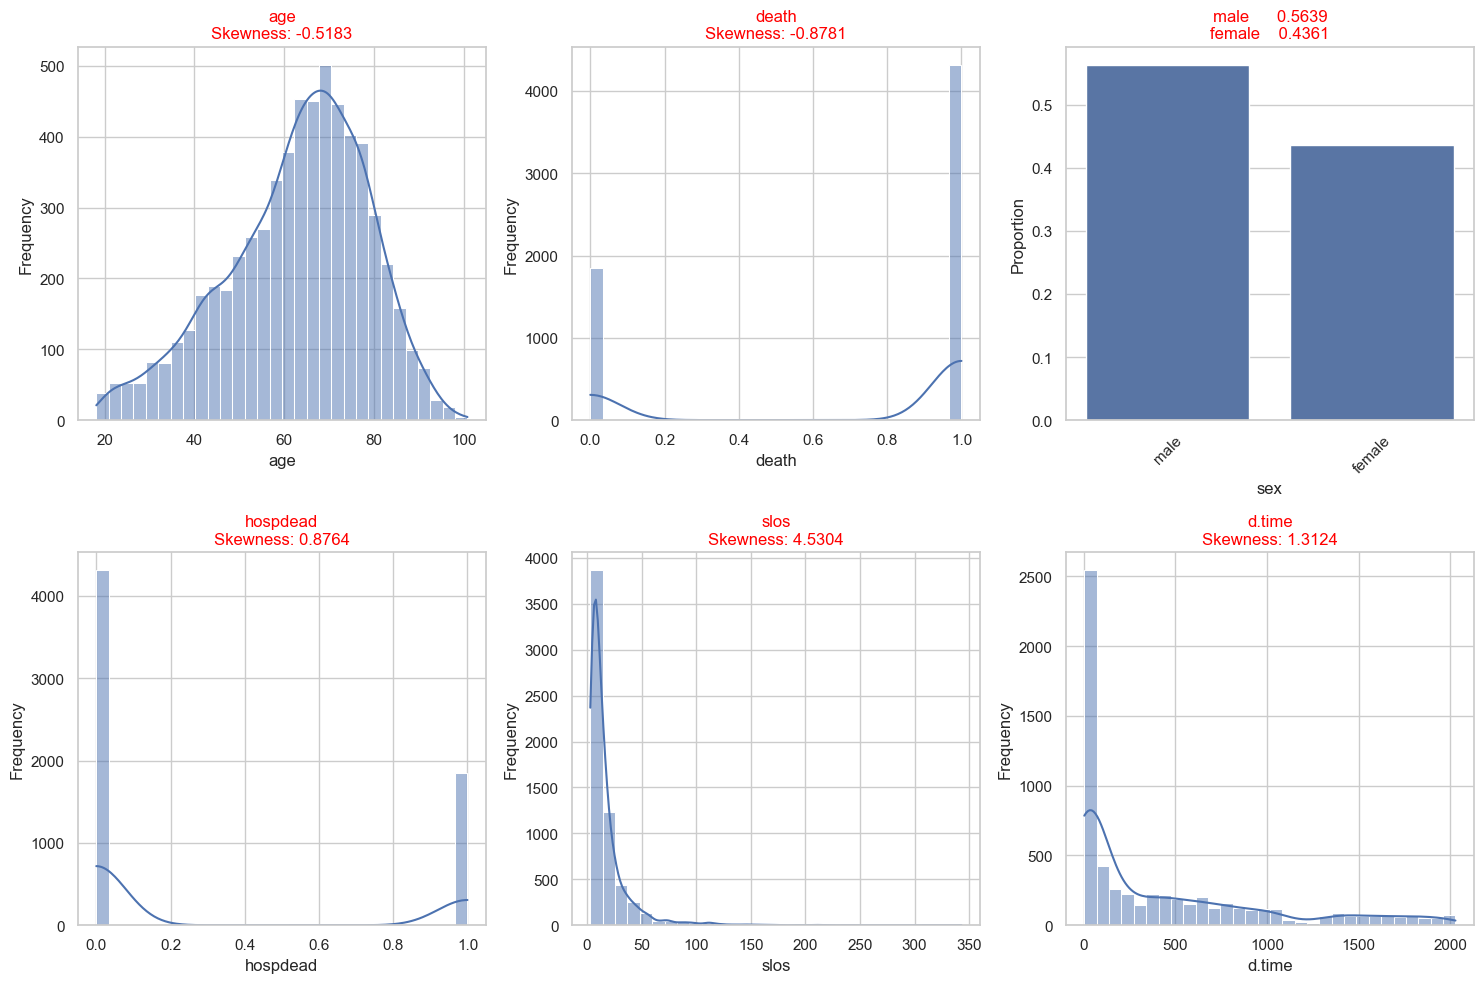

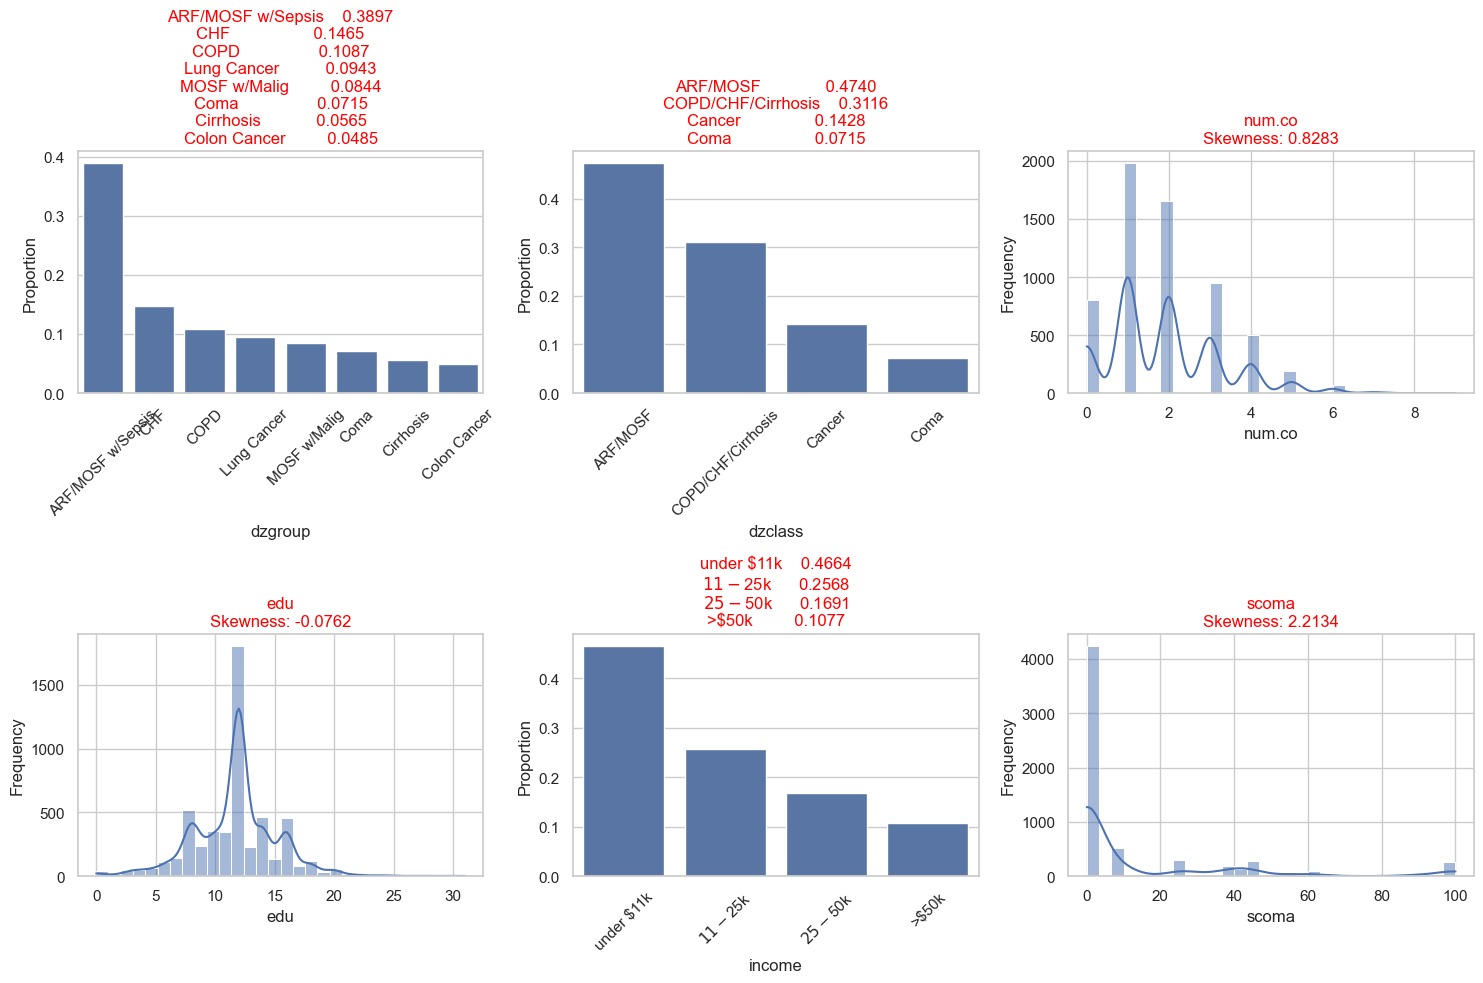

stop
stopped


In [34]:
# Visualize the distributions of the first 6 features in data
visualize_feature_distributions(data.iloc[:, 1:8], save = True, saving_path = 'orginal_6th_feature_distributions.png')
visualize_feature_distributions(data.iloc[:, 7:14], save = True, saving_path = 'orginal_6_12th_feature_distributions.png')
# visualize_feature_distributions(data)
print("stop")
print("stopped")

## What to do on top the original data after observing their feature distributions?

- **Detect outliers and filter them out:**
 
    **Some features appearently have outliers by checking the skewness.**

    We can set a threshold on skewness and filter the features that need to be filtered outliers out.

    The sepcific algorithm to filter outliers can be designed later, but we know we shold filter these features.

    This filtering means we remove the rows that contain one or more of these outliers under these selected features.

- **Do necessary transformations on some features**

    **By doing transformations, we expect to explain the variation in target variable more**

    Take a simple logrithm transformation on some variables might be enough to spread off our feature values and is easy to convert them back.

In [38]:
# take out the skewness of the numerical features
feature_skewness = DataStats.distribution_stats(data).iloc[:, 1:]
feature_skewness

There is at least one variable that is highly skewed
There is at least one variable that has more outliers
There is no vairable that is normally distributed


/Users/gufeng/ENTER/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,age,death,hospdead,slos,d.time,num.co,edu,scoma,charges,totcst,...,bili,crea,sod,ph,glucose,bun,urine,adlp,adls,adlsc
count,6.164000e+03,6164.000000,6164.000000,6164.000000,6164.000000,6164.000000,5.330000e+03,6163.000000,6.046000e+03,5538.000000,...,4437.000000,6123.000000,6.163000e+03,4.708000e+03,3153.000000,3238.000000,2.886000e+03,2435.000000,4557.000000,6164.000000
mean,6.284817e+01,0.701006,0.299319,17.382706,439.627515,1.889520,1.172458e+01,13.066851,5.880309e+04,30783.653145,...,2.660886,1.776941,1.375676e+02,7.414625e+00,159.723121,32.245552,2.229946e+03,1.186037,1.662497,1.855109
std,1.571918e+01,0.457854,0.457997,20.892997,549.711109,1.362782,3.439139e+00,25.884780,9.833895e+04,45256.676773,...,5.549721,1.666017,6.063076e+00,8.118208e-02,88.021562,26.585003,1.485341e+03,1.758268,2.238762,2.051290
min,1.811899e+01,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000e+00,0.000000,1.169000e+03,0.000000,...,0.099991,0.099991,1.110000e+02,6.919922e+00,1.399902,1.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,5.303198e+01,0.000000,0.000000,6.000000,19.000000,1.000000,1.000000e+01,0.000000,1.007450e+04,6135.760725,...,0.500000,0.899902,1.340000e+02,7.379883e+00,102.000000,14.000000,1.175000e+03,0.000000,0.000000,0.000000
50%,6.501599e+01,1.000000,0.000000,11.000000,164.000000,2.000000,1.200000e+01,0.000000,2.547150e+04,14735.332000,...,0.899902,1.199951,1.370000e+02,7.419922e+00,135.000000,23.000000,2.000000e+03,0.000000,1.000000,1.000000
75%,7.437721e+01,1.000000,1.000000,19.000000,692.250000,3.000000,1.400000e+01,9.000000,6.390600e+04,36022.546875,...,1.899902,1.899902,1.410000e+02,7.469727e+00,189.000000,42.000000,3.060000e+03,2.000000,3.000000,3.000000
max,1.008490e+02,1.000000,1.000000,343.000000,2029.000000,9.000000,3.100000e+01,100.000000,1.226766e+06,483556.250000,...,63.000000,18.398438,1.750000e+02,7.769531e+00,1051.000000,300.000000,9.000000e+03,7.000000,7.000000,7.073242
skewness,-5.184428e-01,-0.878319,0.876629,4.531479,1.312692,0.828506,-7.620842e-02,2.213976,4.584197e+00,3.883041,...,4.637215,3.116991,3.466007e-01,-9.503109e-01,2.440688,1.976060,9.586058e-01,1.621204,1.170574,0.974296
kurtosis,-1.487133e-01,-1.228931,-1.231896,33.639484,0.661489,0.652463,1.462599e+00,4.130657,3.048026e+01,21.954285,...,26.229281,13.098301,1.332500e+00,2.781210e+00,10.870927,6.399931,1.221806e+00,1.705213,-0.035569,-0.095492


In [ ]:
# copy the resulting table to clipboard
import pyperclip

def export_df_to_latex_clipboard(df, caption="Model evaluation metrics", label="tab:metrics"):
    latex = r"\begin{table}[!h]" + "\n"
    latex += r"\centering" + "\n"
    latex += rf"\caption{{{caption}}}" + "\n"
    latex += rf"\label{{{label}}}" + "\n"

    # Build header
    header = df.columns.tolist()
    col_format = "c" * len(df.reset_index().columns)  # assume all center aligned
    latex += r"\begin{tabular}{" + col_format + "}\n"
    latex += r"\toprule" + "\n"

    # Column names
    column_names = df.reset_index().columns
    latex += " & ".join([f"\\textbf{{{col}}}" for col in column_names]) + r" \\" + "\n"
    latex += r"\midrule" + "\n"

    # Table body
    for _, row in df.reset_index().iterrows():
        row_str = " & ".join([f"{x:.4f}" if isinstance(x, float) else str(x) for x in row])
        latex += row_str + r" \\" + "\n"

    latex += r"\bottomrule" + "\n"
    latex += r"\end{tabular}" + "\n"
    latex += r"\end{table}"

    # Copy to clipboard
    pyperclip.copy(latex)
    print("✅ LaTeX code copied to clipboard!")

# Usage:
export_df_to_latex_clipboard(feature_skewness.T.round(decimals = 2))

✅ LaTeX code copied to clipboard!


# Start Training models here

<span style = "color: green">

Remove the highly correlated columns that might cause data lack. (Ideas come from Janne)

These variables are: 

['death', 'hospdead', 'd.time', 'id', 'slos']


In [15]:
def remove_risky_features(data, risky_features = ['death', 'hospdead', 'd.time', 'id', 'slos']):
    """
    Remove features from data frame that cause data lacking in the model.
    """
    for feature in risky_features:
        if feature in data.columns:
            data = data.drop(columns=[feature])
    return data

In [16]:
# update the data to remove risky features
print(f"Before removing risky features, the column number of data is {data.shape[1]}")
data = remove_risky_features(data)
print(f"After removing risky features, the column number of data is {data.shape[1]}")

Before removing risky features, the column number of data is 48
After removing risky features, the column number of data is 43


# Code waiting to be added

<span style = "color: red">

Janne and Yazhe provided feature selection methods here and generated the filtered data set with 11 important features. 

This part is waiting to be added to make up the complete pipeline after April 5th. This moment we directly use the processed data set and train models on it due to shortage of time.

<span>

# Model training

<span style = "color: red">

Use the processed data set directly here.

<span>

In [17]:
# read one of the filted data sets for useage
data = pd.read_csv('../data/filtered_data/training_data_ros.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12490 entries, 0 to 12489
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   num__avtisst                   12490 non-null  float64
 1   num__dnrday                    12490 non-null  float64
 2   cat_simple__dnr                12490 non-null  float64
 3   num__adlsc                     12490 non-null  float64
 4   num__prg6m                     12490 non-null  float64
 5   num__adls                      12490 non-null  float64
 6   cat_one_hot__dzgroup_COPD      12490 non-null  float64
 7   num__sps                       12490 non-null  float64
 8   num__aps                       12490 non-null  float64
 9   num__hday                      12490 non-null  float64
 10  cat_one_hot__dzclass_ARF/MOSF  12490 non-null  float64
 11  target                         12490 non-null  float64
dtypes: float64(12)
memory usage: 1.1 MB


In [18]:
# these data have been standardized well
data.describe()

,num__avtisst,num__dnrday,cat_simple__dnr,num__adlsc,num__prg6m,num__adls,cat_one_hot__dzgroup_COPD,num__sps,num__aps,num__hday,cat_one_hot__dzclass_ARF/MOSF,target
count,12490.000000,12490.000000,12490.000000,12490.000000,12490.000000,12490.000000,12490.000000,12490.000000,12490.000000,12490.000000,12490.000000,12490.00000
mean,0.100299,0.601406,-0.145353,0.095602,0.105100,0.069452,0.039661,0.001958,0.030477,0.134567,0.098552,3.00000
std,0.979506,1.939881,0.949307,1.037782,0.968152,1.050947,1.048690,0.890187,0.981924,1.146994,0.999793,1.41427
min,-1.653831,-5.298345,-0.758602,-0.902677,-1.738792,-0.762361,-0.345108,-2.537867,-1.851725,-0.376399,-0.954319,1.00000
25%,-0.766612,-0.463264,-0.758602,-0.902677,-0.668698,-0.762361,-0.345108,-0.607518,-0.673639,-0.376399,-0.954319,2.00000
50%,-0.027264,-0.151323,-0.758602,-0.336038,0.044698,-0.249181,-0.345108,-0.107590,-0.084596,-0.376399,1.047867,3.00000
75%,0.859955,0.732509,1.067256,0.668035,0.758094,0.264000,-0.345108,0.440952,0.553534,0.042434,1.047867,4.00000
max,4.408828,13.886011,2.893115,2.532048,1.828188,2.829904,2.897644,7.162409,5.118616,15.015704,1.047867,5.00000


In [19]:
# build a customized Logistic Regression model
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score

# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Custom feature transformation
def custom_log_odds_features(X):
    # X is (n_samples, 9)
    # Example: add squared terms for nonlinear regression
    X_squared = X ** 2
    intercept = np.ones((X.shape[0], 1))
    return np.hstack([intercept, X, X_squared])

# Logistic loss function (negative log-likelihood)
def loss_fn(beta, X, y):
    z = X @ beta
    p = sigmoid(z)
    # To avoid log(0)
    epsilon = 1e-9
    return -np.mean(y * np.log(p + epsilon) + (1 - y) * np.log(1 - p + epsilon))

# Fit model
def fit_logistic(X, y):
    X_transformed = custom_log_odds_features(X)
    beta_init = np.zeros(X_transformed.shape[1])
    result = minimize(loss_fn, beta_init, args=(X_transformed, y), method='BFGS')
    return result.x  # estimated coefficients

# fit one-vs-rest logistic regression for multiclass classification
def fit_multiclass_logistic_ovr(X, y, num_classes):
    models = {}
    for cls in range(num_classes):
        y_binary = (y == cls).astype(int)  # One-vs-Rest
        beta = fit_logistic(X, y_binary)   # Use your earlier function
        models[cls] = beta
    return models

# Predict for multiclass
def predict_multiclass(X, models):
    X_transformed = custom_log_odds_features(X)
    probs = {}
    for cls, beta in models.items():
        probs[cls] = sigmoid(X_transformed @ beta)
    
    # Combine predictions into a matrix (n_samples x num_classes)
    prob_matrix = np.vstack([probs[cls] for cls in sorted(probs.keys())]).T
    return np.argmax(prob_matrix, axis=1)

In [21]:
from sklearn.metrics import classification_report
# test the custom logistic regression model
def f():
    # Sample data
    X = data.drop("target", axis = 1).values
    y = data["target"].values

    models = fit_multiclass_logistic_ovr(X, y, num_classes=5)
    
    y_pred = predict_multiclass(X, models)
    print(classification_report(y, y_pred))

f()

              precision    recall  f1-score   support

         1.0       0.58      0.78      0.67      2498
         2.0       0.45      0.68      0.54      2498
         3.0       0.38      0.45      0.42      2498
         4.0       0.32      0.31      0.32      2498
         5.0       0.00      0.00      0.00      2498

    accuracy                           0.45     12490
   macro avg       0.35      0.45      0.39     12490
weighted avg       0.35      0.45      0.39     12490



/Users/gufeng/ENTER/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gufeng/ENTER/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gufeng/ENTER/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
